<h1>Reiknum Kernel MNIST gagna</h1>

In [49]:
using MLDatasets, Flux, LinearAlgebra, ProgressMeter
include("DenseNTK.jl"); include("FastNTK.jl")

function load_MNIST()
    """
    Loading the MNIST dataset.
    10 classes of digits from 0 to 9,
    each with 28x28 pixel dimensions.
    X: Grayscale vector, Y: Correct label.
    """

    X_training, Y_training = MNIST(split = :train)[:]
    X_testing, Y_testing = MNIST(split = :test)[:]
    X_training = Flux.flatten(X_training)
    X_testing = Flux.flatten(X_testing)
    Y_training = Flux.onehotbatch(Y_training, 0:9)
    Y_testing = Flux.onehotbatch(Y_testing, 0:9)
    return X_training, Y_training, X_testing, Y_testing
end

load_MNIST (generic function with 1 method)

In [7]:
# Model frá https://towardsdatascience.com/flux-jl-on-mnist-variations-of-a-theme-c3cd7a949f8c

model4LS = Chain(
  DenseNTK(28 * 28, 16, sigmoid),        # 784 x 16 + 16 = 12560 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 10, sigmoid)              #  16 x 10 + 10 =   170 parameters
)                                     #             --> 13274 parameters total

model3LS = Chain(
  DenseNTK(28 * 28, 60, sigmoid),        # 784 x 60 + 60 = 47100 parameters
  DenseNTK(60, 60, sigmoid),             #  60 x 60 + 60 =  3660 parameters
  DenseNTK(60, 10, sigmoid)              #  60 x 10 + 10 =   610 parameters
)                                     #             --> 51370 parameters total

model2LR = Chain(
  DenseNTK(28 * 28, 32, relu),           # 784 x 32 + 32 = 25120 parameters
  DenseNTK(32, 10),                      #  32 x 10 + 10 =   330 parameters
  softmax                             #             --> 25450 parameters total
)

Chain(
  DenseNTK(Float32[1.0134795 -1.8409233 … -0.06203301 1.3047152; -1.0478306 -0.8514095 … -0.20743605 -0.39558086; … ; -0.398571 -0.5391381 … -0.35770407 -0.49299246; -0.2518886 -0.085218936 … 1.0400761 -0.18183598], Float32[-0.41707072, 1.1808552, -0.4044544, -1.4198488, -1.0804428, -0.9743967, -0.48373657, -1.7125872, -1.4910898, 2.192092  …  -0.39269972, -0.7648503, 0.74232996, -0.7881364, 1.2768657, -2.287204, 0.7653722, 0.22522004, -0.065353684, 1.5671281], NNlib.relu),  # 25_120 parameters
  DenseNTK(Float32[-1.4166496 -0.29865876 … 0.47361955 -0.83278775; 0.46377715 -0.7933866 … 0.2963305 -2.2011144; … ; 1.2114668 0.75380397 … -0.67472494 1.1268188; 1.1552922 -1.5173216 … 0.06175506 0.64076716], Float32[-1.1195158, -0.25249234, 0.148034, 0.5466499, 1.5117371, 0.045058187, 0.046494678, 2.7985766, -0.2824836, -1.1515273], identity),  # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.711 KiB.

In [44]:
N=100
x = load_MNIST()[1][:,1:N];

eig_fix(K) = abs.(eigen(K).values)

eig_fix (generic function with 1 method)

In [19]:
K4LS = kernel(model4LS, x, true)
#K3LS = kernel(model3LS, x, true)
#K2LR = kernel(model2LR, x, true)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:49


1000×1000 Matrix{Float64}:
 0.0518662    0.051888     0.0518788    …  0.000722438  0.000720972
 0.051888     0.0519104    0.0519007       0.000723958  0.00072242
 0.0518788    0.0519007    0.0518918       0.000725239  0.000723714
 0.0518914    0.0519134    0.0519043       0.000728155  0.000726703
 0.0518723    0.0518943    0.051885        0.000723964  0.000722467
 0.0518707    0.0518926    0.0518835    …  0.000724954  0.000723483
 0.0518854    0.0519074    0.0518983       0.000726535  0.000725028
 0.0518875    0.0519095    0.0519003       0.000723753  0.000722172
 0.0518775    0.0518994    0.0518903       0.000725324  0.000723832
 0.0518344    0.0518561    0.0518471       0.000724113  0.000722676
 ⋮                                      ⋱               
 0.000721644  0.000723188  0.000724429     0.0154589    0.0154666
 0.000719512  0.000720965  0.000722258     0.0154656    0.0154738
 0.000719918  0.000721463  0.00072267      0.0154511    0.0154592
 0.000719615  0.000721056  0.000722343 

In [20]:
eig1 = eig_fix(K3LS)
eig2 = eig_fix(K2LR)
eig3 = eig_fix(K4LS)

1000-element Vector{Float64}:
 1.0416805314827912e-11
 1.546976310671029e-11
 2.5879748987295652e-11
 2.720787911986022e-11
 2.8306581203849105e-11
 3.1624277225259695e-11
 3.288156598610149e-11
 3.561933020147426e-11
 3.608714456034366e-11
 3.715502537660695e-11
 ⋮
 4.3574558744644385
 5.003761705409776
 5.197916547757945
 5.324264098824629
 5.906264702784812
 7.522112769673298
 7.829620356122388
 7.97797299077248
 8.42307842601754

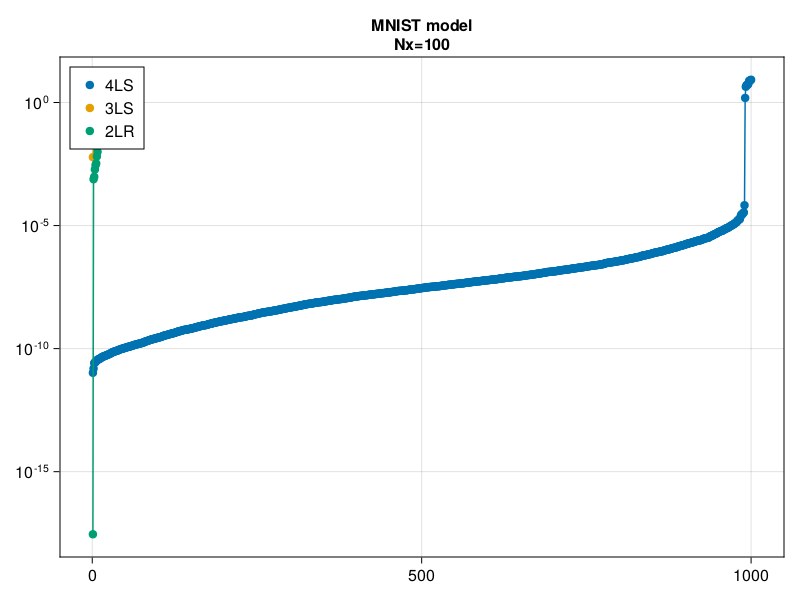

In [21]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1], yscale=log10, title="MNIST model\nNx=$N")

CairoMakie.scatter!(eig3, label="4LS")
CairoMakie.lines!(eig3)

CairoMakie.scatter!(eig1, label="3LS")
CairoMakie.lines!(eig1)

CairoMakie.scatter!(eig2, label="2LR")
CairoMakie.lines!(eig2)

axislegend(ax1,position=:lt)
fig

In [45]:
Kold = kernel(model4LS, x, true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


300×300 Matrix{Float64}:
  0.084631      0.0845915     0.0845699    …  -0.000353642  -0.000350629
  0.0845915     0.084556      0.084534        -0.000350466  -0.000347494
  0.0845699     0.084534      0.084517        -0.000345954  -0.000343237
  0.0845889     0.0845526     0.0845335       -0.000351641  -0.000348847
  0.0846231     0.0845864     0.0845679       -0.00035105   -0.000348321
  0.0846029     0.0845648     0.0845464    …  -0.000350905  -0.000348161
  0.0846193     0.0845828     0.0845629       -0.000353448  -0.000350553
  0.0846521     0.0846131     0.0845932       -0.000353946  -0.000351089
  0.0846213     0.0845856     0.0845659       -0.000353216  -0.000350406
  0.0845882     0.0845513     0.084531        -0.000350698  -0.00034774
  ⋮                                        ⋱                
 -0.000352992  -0.000349879  -0.00034528       0.0101543     0.0101964
 -0.000352303  -0.000349136  -0.000344762      0.0101421     0.0101845
 -0.000352033  -0.000348906  -0.000344641  

In [51]:
Knew = faster_kernel(model4LS,x)

300×300 Matrix{Float64}:
  0.084631     -0.00213914   -0.0001349    …   0.000224324  -0.000350629
 -0.00213914    0.0806474    -0.000154777     -0.00073297   -0.000158182
 -0.0001349    -0.000154777   0.0769146       -1.43794e-5   -0.000532742
 -0.000211751  -0.000306369   0.000363329     -0.000435067  -0.000510641
 -0.000345079   6.42029e-5    0.000378033      8.51304e-5    0.000246932
  0.00146836    6.35757e-5   -0.00065156   …   0.000610461  -0.000585978
 -0.00127996   -0.000448929   0.000540383      0.000416079   0.000423865
 -0.000472058  -0.000448832   0.000208923      0.000592536  -0.000140167
  0.000223872  -0.000738393  -1.53894e-5       0.0710855    -0.000246287
 -0.000356035  -0.000159144  -0.000532851     -0.000247377   0.010239
  ⋮                                        ⋱                
 -0.00213866    0.0806442    -0.000150675     -0.000726742  -0.000157935
 -0.00014169   -0.000150649   0.0769419       -1.33162e-5   -0.000535005
 -0.0002127    -0.000307171   0.000363598

In [42]:
round.(eigen(Kold).values, digits=13) == round.(eigen(Knew).values, digits=13)

true